# Проект e-commerce.
Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:
1. Сколько у нас пользователей, которые совершили покупку только один раз?
2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?
3. По каждому товару определить, в какой день недели товар чаще всего покупается.
4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.
5. Напиши функцию на python, позволяющую строить когортный анализ. В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц. Описание подхода можно найти тут.
6. Построй RFM-кластеры для пользователей. Выведи для каждого кластера средние значения метрик R, F, M (и опиши подробно, как были построены метрики R, F, M). Описание подхода можно найти тут.

Файлы:

1. **olist_customers_dataset.csv** — таблица с уникальными идентификаторами пользователей:
    - customer_id — позаказный идентификатор пользователя (аналог номера паспорта)
    - customer_unique_id —  уникальный идентификатор пользователя
    - customer_zip_code_prefix —  почтовый индекс пользователя
    - customer_city —  город доставки пользователя
    - customer_state —  штат доставки пользователя


2. **olist_orders_dataset.csv** —  таблица заказов:
    - order_id —  уникальный идентификатор заказа (номер чека)
    - customer_id —  позаказный идентификатор пользователя (аналог номера паспорта)
    - order_status —  статус заказа
    - order_purchase_timestamp —  время создания заказа
    - order_approved_at —  время подтверждения оплаты заказа
    - order_delivered_carrier_date —  время передачи заказа в логистическую службу
    - order_delivered_customer_date —  время доставки заказа
    - order_estimated_delivery_date —  обещанная дата доставки


3. **olist_order_items_dataset.csv** —  товарные позиции, входящие в заказы:
    - order_id —  уникальный идентификатор заказа (номер чека)
    - order_item_id —  идентификатор товара внутри одного заказа
    - product_id —  ид товара (аналог штрихкода)
    - seller_id — ид производителя товара
    - shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
    - price —  цена за единицу товара
    - freight_value —  вес товара


Уникальные статусы заказов в таблице **olist_order_dataset**:
- **created** —  создан
- **approved** —  подтверждён
- **invoiced** —  выставлен счёт
- **processing** —  в процессе сборки заказа
- **shipped** —  отгружен со склада
- **delivered** —  доставлен пользователю
- **unavailable** —  недоступен
- **canceled** —  отменён

In [1]:
import pandas as pd

from operator import attrgetter
from datetime import timedelta

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#  загрузим данные
df_customers = pd.read_csv('olist_customers_dataset.csv')
df_order_items = pd.read_csv('olist_order_items_dataset.csv')
df_orders = pd.read_csv('olist_orders_dataset.csv')

Рассмотрим пример структуры данных по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

In [3]:
df_order_items.query('order_id == "00143d0f86d6fbd9f9b38ab440ac16f5"')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


In [4]:
df_orders.query('order_id == "00143d0f86d6fbd9f9b38ab440ac16f5"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
36265,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06 00:00:00


In [5]:
df_customers.query('customer_id == "2e45292979b9b2700ea09560eeb0f803"')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
58260,2e45292979b9b2700ea09560eeb0f803,bb8a37225e0279ac8a274c9765617eaf,74663,goiania,GO


Посмотрим общую информацию по таблицам, их размерам, типам данных и наличию отсутствующих значений.

In [6]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [7]:
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [8]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [9]:
# Видим, что в таблице orders присутствуют не все значения.
# Выведем более наглядно, в каких столбцах и сколько есть отсутствующих значений
df_orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

В описание данных, на мой взгляд, закралась ошибка. "order_approved_at" описывается как "время подтверждения **оплаты** заказа". Но мы видим, что эта дата стоит у заказов, которые имеют статусы "подтвержден" и "выставлен счет", то есть статусы, которые идут еще до оплаты заказа. Следовательно, "order_approved_at" - это время подтверждения заказа.

In [10]:
df_orders.query('order_status=="approved"')\
    .loc[:, ['order_status', 'order_approved_at', 'order_delivered_carrier_date']]\
    .head()

,order_status,order_approved_at,order_delivered_carrier_date
44897,approved,2017-02-06 20:30:19,NaN
88457,approved,2017-04-30 20:32:41,NaN


In [11]:
df_orders.query('order_status=="invoiced"')\
    .loc[:, ['order_status', 'order_approved_at', 'order_delivered_carrier_date']]\
    .head()

,order_status,order_approved_at,order_delivered_carrier_date
6,invoiced,2017-04-13 13:25:17,NaN
103,invoiced,2018-08-07 06:15:14,NaN
455,invoiced,2017-08-01 18:32:30,NaN
1833,invoiced,2017-05-05 22:45:12,NaN
2116,invoiced,2017-11-29 08:56:23,NaN


In [12]:
df_orders.query('order_status=="processing"')\
    .loc[:, ['order_status', 'order_approved_at', 'order_delivered_carrier_date']]\
    .head()

,order_status,order_approved_at,order_delivered_carrier_date
128,processing,2017-09-03 14:30:09,NaN
324,processing,2016-10-06 15:51:05,NaN
741,processing,2017-11-24 23:15:15,NaN
1192,processing,2017-11-18 02:15:40,NaN
1516,processing,2017-02-13 18:43:55,NaN


In [13]:
df_orders.query('order_status=="shipped"')\
    .loc[:, ['order_status', 'order_approved_at', 'order_delivered_carrier_date']]\
    .head()

,order_status,order_approved_at,order_delivered_carrier_date
44,shipped,2018-06-05 04:31:18,2018-06-05 14:32:00
154,shipped,2018-01-11 02:32:30,2018-01-11 19:39:23
162,shipped,2017-05-11 11:45:14,2017-05-11 13:21:47
231,shipped,2017-11-18 19:50:31,2017-11-22 17:28:34
299,shipped,2018-06-28 13:11:09,2018-07-04 15:20:00


### 1. Сколько у нас пользователей, которые совершили покупку только один раз?

Для начала следует разобраться, что мы будем считать совершенной покупкой. Считаю, что этот вопрос следовало бы задать продакт-менеджеру Василию.
Есть два варианта: 1) считать покупкой факт совершения оплаты за заказ, 2) считать покупкой факт доставки заказа. Я склоняюсь ко второму варианту, так как обычно юридически переход права собственности происходит в момент передачи товара. Также те покупатели, которые уже получили заказ, прошли полный цикл взаимодействия с нашим сервисом и рассматривать именно их (и разбираться в причинах, почему они сделали заказ лишь единожды) мне кажется более разумным в данной задаче.

Наличие даты осуществленной доставки еще не говорит нам о совершении покупки, так как есть случаи, когда покупатель отказывается от заказа при доставке или после нее. Поэтому за совершенные покупки примем наличие статуса заказа "delivered".

In [14]:
df_customers.groupby('customer_unique_id')\
    .agg({'customer_id': 'count'})\
    .reset_index()\
    .sort_values('customer_id')

,customer_unique_id,customer_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1
63580,a926cfc9bc7b082335de50450f48eec9,1
63579,a926aae38267e7f54e67de9b5775d0a5,1
63578,a92605ec492805540520d3a73aaeeb6e,1
63577,a925c3e5df82fdc6082f1383d2834998,1
...,...,...
76082,ca77025e7201e3b30c44b472ff346268,7
37797,6469f99c1f9dfae7733b25662e7f1782,7
10354,1b6c7548a2a1f9037c1fd3ddfed95f33,7
23472,3e43e6105506432c953e165fb2acf44c,9


Так как одному значению **customer_unique_id** может соответствовать несколько значений **customer_id**, то подсчет покупателей нужно производить именно по **customer_unique_id**.

In [15]:
# отсечем лишние данные, не нужные для подсчета
df_orders_delivered = df_orders.query('order_status=="delivered"')\
                            .loc[:, ['customer_id', 'order_id']]

df_orders_delivered

,customer_id,order_id
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159
...,...,...
99436,39bd1228ee8140590ac3aca26f2dfe00,9c5dedf39a927c1b2549525ed64a053c
99437,1fca14ff2861355f6e5f14306ff977a7,63943bddc261676b46f01ca7ac2f7bd8
99438,1aa71eb042121263aafbe80c1b562c9c,83c1379a015df1e13d02aae0204711ab
99439,b331b74b18dc79bcdf6532d51e1637c1,11c177c8e97725db2631073c19f07b62


In [16]:
# присоединим к получившейся таблице столбец соответствий customer_unique_id
df_orders_delivered = df_orders_delivered.merge(df_customers.loc[:, ['customer_id', 'customer_unique_id']], 
                                                on='customer_id', 
                                                how='left')

In [17]:
# видим, что присоединили верно, количество строк не поменялось
df_orders_delivered

,customer_id,order_id,customer_unique_id
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6
...,...,...,...
96473,39bd1228ee8140590ac3aca26f2dfe00,9c5dedf39a927c1b2549525ed64a053c,6359f309b166b0196dbf7ad2ac62bb5a
96474,1fca14ff2861355f6e5f14306ff977a7,63943bddc261676b46f01ca7ac2f7bd8,da62f9e57a76d978d02ab5362c509660
96475,1aa71eb042121263aafbe80c1b562c9c,83c1379a015df1e13d02aae0204711ab,737520a9aad80b3fbbdad19b66b37b30
96476,b331b74b18dc79bcdf6532d51e1637c1,11c177c8e97725db2631073c19f07b62,5097a5312c8b157bb7be58ae360ef43c


In [18]:
# сгруппируем заказы по customer_unique_id и 
# посчитаем их количество на каждого покупателя,
# затем выделим только тех, кто совершил покупку один раз, 
# и посмотрим их количество (что соответствует количеству строк)
df_orders_delivered.groupby('customer_unique_id')\
    .agg({'order_id': 'count'})\
    .reset_index()\
    .rename(columns={'order_id': 'count'})\
    .query('count==1')\
    .shape[0]

90557

In [19]:
# посмотрим количество всех уникальных покупателей в нашей базе данных
df_customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

Видим, что из 96 096 уникальных покупателей, 90 557 совершили одну покупку.

### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [20]:
df_orders.query('((order_status=="unavailable")|(order_status=="canceled"))').order_estimated_delivery_date.isna().sum()

0

Есть две причины, почему заказ не доставлен покупателю: заказ недоступен (unavailable) или отменен (canceled). Так как у нас нет заказов, у которых был бы такой статус и при этом отсутствовала предполагаемая дата доставки (order_estimated_delivery_date), то принадлежность к месяцу будем считать именно по этой дате.

Но для начала необходимо исправить форматы дат, которые сейчас находятся в простом текстовом виде.

In [21]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [22]:
cols = df_orders.columns[3:]

In [23]:
df_orders[cols] = df_orders[cols].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')

In [24]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [25]:
df_orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [26]:
# заодно исправим формат даты в другой таблице
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [27]:
df_order_items['shipping_limit_date'] = pd.to_datetime(df_order_items['shipping_limit_date'],
                                                      format='%Y-%m-%d %H:%M:%S')

In [28]:
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [29]:
df_order_items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [30]:
# из предполагаемой даты доставки выделим месяц в отдельный столбец
df_orders['est_delivery_month'] = df_orders['order_estimated_delivery_date'].dt.to_period('M')

In [31]:
df_orders_undelivered = df_orders.query('(order_status=="unavailable")|(order_status=="canceled")')
df_orders_undelivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,est_delivery_month
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05,2017-12
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14,2018-08
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16,2018-02
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22,2018-02
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05,2017-09


In [32]:
# недоставленных заказов всего
df_orders_undelivered.shape[0]

1234

In [33]:
# сколько недоставленных заказов в разбивке по причинам их недоставленности
df_orders_undelivered.groupby('order_status')\
    .agg({'order_id': 'count'})\
    .reset_index()\
    .rename(columns={'order_id': 'count'})

,order_status,count
0,canceled,625
1,unavailable,609


In [34]:
# посчитаем, сколько заказов недоставлено каждый месяц по каждой из причин
df_orders_undelivered_by_month = df_orders_undelivered\
    .groupby(['order_status', 'est_delivery_month'])\
    .agg({'order_id':'count'})\
    .reset_index()\
    .rename(columns={'order_id': 'count'})

df_orders_undelivered_by_month

,order_status,est_delivery_month,count
0,canceled,2016-09,1
1,canceled,2016-10,3
2,canceled,2016-11,14
3,canceled,2016-12,8
4,canceled,2017-02,2
5,canceled,2017-03,26
6,canceled,2017-04,22
7,canceled,2017-05,23
8,canceled,2017-06,29
9,canceled,2017-07,21


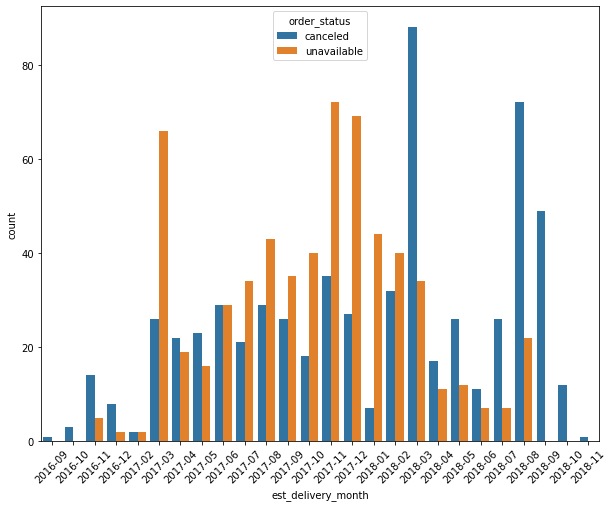

In [35]:
# для наглядности визуализируем полученные данные
plt.figure(figsize=(10,8))
plt.xticks(rotation=45)
sns.barplot(data=df_orders_undelivered_by_month, 
            x='est_delivery_month',
            y='count',
            hue='order_status');

In [36]:
# перегруппируем данные, чтобы не пропустить нулевые значения
df_orders_undelivered_by_month_pivot = df_orders_undelivered_by_month\
    .pivot_table(columns='order_status', 
                 index='est_delivery_month', 
                 values='count')\
    .fillna(0)\
    .reset_index()

df_orders_undelivered_by_month_pivot

order_status,est_delivery_month,canceled,unavailable
0,2016-09,1.0,0.0
1,2016-10,3.0,0.0
2,2016-11,14.0,5.0
3,2016-12,8.0,2.0
4,2017-02,2.0,2.0
5,2017-03,26.0,66.0
6,2017-04,22.0,19.0
7,2017-05,23.0,16.0
8,2017-06,29.0,29.0
9,2017-07,21.0,34.0


In [37]:
# Посчитаем, сколько заказов в месяц в среднем отменяются
df_orders_undelivered_by_month_pivot.canceled.mean()

24.03846153846154

In [38]:
# Посчитаем, сколько заказов в месяц в среднем недоступны к доставке
df_orders_undelivered_by_month_pivot.unavailable.mean()

23.423076923076923

Всего недоставленных заказов с сентября 2016г. по ноябрь 2018г. - 1 234, из них отменены 625 заказов, а недоступны к доставке оказались 609.
В среднем за период ежемесячно отменяются 24.04 заказов и 23.42 заказов недоступны к доставке. В последние 3 месяца (сентябрь-ноябрь 2018) недоступных к доставке заказов не было. С марта 2018 года в причинах недоставки заказов преобладают отмененные заказы.

### 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

Полагаю, что в формулировке задания имеется в виду факт заказа, вне зависимости от того, был ли товар оплачен и доставлен, поэтому день недели буду брать из даты заказа товара, исключая недоступные к доставке и отмененные заказы. 

Также полагаю, что нас интересует количество заказанного товара, а не количество заказов без учета количества товара в заказе. Так как эти данные вероятно нужны для планирования его закупки и хранения на складе. Этот вопрос тоже хорошо бы уточнить у продакт-менеджера Василия.

In [39]:
# отберем необходимые столбцы из таблицы с заказами
df_order_products = df_orders\
    .query('(order_status != "canceled")&(order_status != "unavailable")')\
    .loc[:, ['order_id', 'order_purchase_timestamp']]

df_order_products.head()

,order_id,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39


In [40]:
# выделим из даты день недели
df_order_products['week_day'] = df_order_products\
                                    .order_purchase_timestamp\
                                    .dt.day_name()

In [41]:
# присоединим столбец с идентификатором товаров из таблицы с товарами
df_order_products = df_order_products\
                        .merge(df_order_items.loc[:, ['order_id', 'product_id', 'order_item_id']],
                              on='order_id',
                              how='left')
df_order_products

,order_id,order_purchase_timestamp,week_day,product_id,order_item_id
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,Monday,87285b34884572647811a353c7ac498a,1.0
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,Tuesday,595fac2a385ac33a80bd5114aec74eb8,1.0
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,Wednesday,aa4383b373c6aca5d8797843e5594415,1.0
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,Saturday,d0b61bfb1de832b15ba9d266ca96e5b0,1.0
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,Tuesday,65266b2da20d04dbe00c5c2d3bb7859e,1.0
...,...,...,...,...,...
112104,63943bddc261676b46f01ca7ac2f7bd8,2018-02-06 12:58:58,Tuesday,f1d4ce8c6dd66c47bbaa8c6781c2a923,1.0
112105,83c1379a015df1e13d02aae0204711ab,2017-08-27 14:46:43,Sunday,b80910977a37536adeddd63663f916ad,1.0
112106,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,Monday,d1c427060a0f73f6b889a5c7c61f2ac4,1.0
112107,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,Monday,d1c427060a0f73f6b889a5c7c61f2ac4,2.0


In [42]:
# сгруппируем данные и посчитаем, в какой день недели сколько раз товар был заказан
df_order_products_by_weekday = df_order_products.groupby(['product_id', 'week_day'])\
    .agg({'order_item_id': 'count'})\
    .reset_index()\
    .rename(columns={'order_item_id': 'quantity'})\
    .sort_values(['product_id', 'week_day'])

df_order_products_by_weekday

,product_id,week_day,quantity
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1
...,...,...,...
60885,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1
60886,fffdb2d0ec8d6a61f0a0a0db3f25b441,Sunday,1
60887,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1
60888,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2


In [43]:
# найдем максимальное число заказов каждого товара в какой-либо из дней недели
df_order_products_by_weekday_max = df_order_products_by_weekday.groupby('product_id')\
    .agg({'quantity': 'max'})\
    .reset_index()\
    .rename(columns={'quantity': 'max_quantity'})

df_order_products_by_weekday_max

,product_id,max_quantity
0,00066f42aeeb9f3007548bb9d3f33c38,1
1,00088930e925c41fd95ebfe695fd2655,1
2,0009406fd7479715e4bef61dd91f2462,1
3,000b8f95fcb9e0096488278317764d19,1
4,000d9be29b5207b54e86aa1b1ac54872,1
...,...,...
32724,fff6177642830a9a94a0f2cba5e476d1,1
32725,fff81cc3158d2725c0655ab9ba0f712c,1
32726,fff9553ac224cec9d15d49f5a263411f,1
32727,fffdb2d0ec8d6a61f0a0a0db3f25b441,2


In [44]:
# посмотрим, в какие дни недели товар был заказан максимальное число раз
df_order_products_by_weekday\
    .merge(df_order_products_by_weekday_max,
           on='product_id',
           how='left')\
    .query('quantity == max_quantity')\
    .iloc[:, :3]\
    .sort_values(['quantity', 'product_id', 'week_day'])

,product_id,week_day,quantity
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1
...,...,...,...
13462,389d119b48cf3043d311335e499d9c6b,Thursday,67
20013,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
40825,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
36311,99a4788cb24856965c36a24e339b6058,Monday,92


Теперь мы знаем, в какой день покупается больше всего товара по каждому из наших товаров. Например, товар с идентификатором "422879e10f46682990de24d770e7f83d" чаще всего покупается по средам - 93 раза.

В то же время, вероятно, для маркетинговых целей необходимо узнать частоту заказов без учета количества товара в заказе. Рассчитаем и эти показатели.

In [45]:
df_order_products_count = df_order_products\
    .groupby(['product_id', 'week_day'])\
    .agg({'order_id': 'nunique'})\
    .reset_index()\
    .rename(columns={'order_id': 'count'})\
    .sort_values(['count', 'product_id', 'week_day'])

df_order_products_count

,product_id,week_day,count
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1
...,...,...,...
20013,53b36df67ebb7c41585e8d54d6772e08,Tuesday,70
36314,99a4788cb24856965c36a24e339b6058,Thursday,71
36310,99a4788cb24856965c36a24e339b6058,Friday,74
40825,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,75


In [46]:
df_order_products_count_max = df_order_products_count\
    .groupby('product_id')\
    .agg({'count': 'max'})\
    .reset_index()\
    .rename(columns={'count': 'max_num'})

df_order_products_count_max

,product_id,max_num
0,00066f42aeeb9f3007548bb9d3f33c38,1
1,00088930e925c41fd95ebfe695fd2655,1
2,0009406fd7479715e4bef61dd91f2462,1
3,000b8f95fcb9e0096488278317764d19,1
4,000d9be29b5207b54e86aa1b1ac54872,1
...,...,...
32724,fff6177642830a9a94a0f2cba5e476d1,1
32725,fff81cc3158d2725c0655ab9ba0f712c,1
32726,fff9553ac224cec9d15d49f5a263411f,1
32727,fffdb2d0ec8d6a61f0a0a0db3f25b441,2


In [47]:
# посмотрим, в какие дни недели товар был заказан максимальное число раз 
# (без учета количества товара в заказе)
df_order_products_count\
    .merge(df_order_products_count_max,
           on='product_id',
           how='left')\
    .query('count == max_num')\
    .iloc[:, :3]\
    .sort_values(['count', 'product_id', 'week_day'])

,product_id,week_day,count
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1
...,...,...,...
60876,422879e10f46682990de24d770e7f83d,Thursday,58
60880,d1c427060a0f73f6b889a5c7c61f2ac4,Monday,60
60885,53b36df67ebb7c41585e8d54d6772e08,Tuesday,70
60888,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,75


Так мы теперь видим, в какие дни недели каждый товар заказывался чаще всего (без учета его количества в заказе). Например, тот же товар с идентификатором "422879e10f46682990de24d770e7f83d" чаще всего заказывается по четвергам, а не средам.

Совместим два вычисленных показателя и посчитаем, сколько заказанного товара приходится в среднем на каждый день недели. И в какой день недели это число максимально для каждого из товаров.

In [48]:
df_order_products_by_weekday_avg = df_order_products_by_weekday\
    .merge(df_order_products_count,
           on=['product_id', 'week_day'])

df_order_products_by_weekday_avg

,product_id,week_day,quantity,count
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1,1
3,000b8f95fcb9e0096488278317764d19,Friday,1,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1,1
...,...,...,...,...
60885,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1,1
60886,fffdb2d0ec8d6a61f0a0a0db3f25b441,Sunday,1,1
60887,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1,1
60888,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2,2


In [49]:
# в отдельный столбец запишем среднее количество заказанного товара в каждый из дней недели
df_order_products_by_weekday_avg['average'] = df_order_products_by_weekday_avg['quantity'] / df_order_products_by_weekday_avg['count']

df_order_products_by_weekday_avg.head()

,product_id,week_day,quantity,count,average
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1,1,1.0
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1,1,1.0
2,0009406fd7479715e4bef61dd91f2462,Thursday,1,1,1.0
3,000b8f95fcb9e0096488278317764d19,Friday,1,1,1.0
4,000b8f95fcb9e0096488278317764d19,Wednesday,1,1,1.0


In [50]:
#  выделим максимальные средние значения
df_order_products_by_weekday_avg_max = df_order_products_by_weekday_avg\
    .groupby('product_id')\
    .agg({'average': 'max'})\
    .reset_index()\
    .rename(columns={'average': 'max_avg'})

df_order_products_by_weekday_avg_max.head()

,product_id,max_avg
0,00066f42aeeb9f3007548bb9d3f33c38,1.0
1,00088930e925c41fd95ebfe695fd2655,1.0
2,0009406fd7479715e4bef61dd91f2462,1.0
3,000b8f95fcb9e0096488278317764d19,1.0
4,000d9be29b5207b54e86aa1b1ac54872,1.0


In [51]:
# посмотрим, в какие дни недели товар был в среднем заказан больше всего
df_order_products_by_weekday_avg\
    .merge(df_order_products_by_weekday_avg_max,
           on='product_id',
           how='left')\
    .query('average == max_avg')\
    .iloc[:, :5]\
    .sort_values(['average', 'product_id', 'week_day'])

,product_id,week_day,quantity,count,average
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1,1,1.0
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1,1,1.0
2,0009406fd7479715e4bef61dd91f2462,Thursday,1,1,1.0
3,000b8f95fcb9e0096488278317764d19,Friday,1,1,1.0
4,000b8f95fcb9e0096488278317764d19,Wednesday,1,1,1.0
...,...,...,...,...,...
812,03e1c946c0ddfc58724ff262aef08dff,Monday,12,1,12.0
16452,44a5d24dd383324a421569ca697b13c2,Wednesday,14,1,14.0
13275,37eb69aca8718e843d897aa7b82f462d,Monday,15,1,15.0
32666,89b190a046022486c635022524a974a8,Thursday,15,1,15.0


In [52]:
df_order_products_by_weekday_avg\
    .merge(df_order_products_by_weekday_avg_max,
           on='product_id',
           how='left')\
    .query('average == max_avg')\
    .iloc[:, :5]\
    .sort_values(['average', 'product_id', 'week_day'])\
    .query('product_id=="422879e10f46682990de24d770e7f83d"')

,product_id,week_day,quantity,count,average
15815,422879e10f46682990de24d770e7f83d,Wednesday,93,54,1.722222


Таким образом мы видим, в какой день в среднем заказывается больше всего каждого товара. Так, например, приведенный в пример товар с идентификатором "422879e10f46682990de24d770e7f83d" больше всего заказывается по средам - 1,72 единицы товара.

### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

За дату покупки примем дату заказа покупателем.

In [53]:
# отсечем отмененные и недоступные к доставке заказы, 
# а также ненужные нам сейчас столбцы
df_customer_orders = df_orders\
    .query('(order_status != "canceled")&(order_status != "unavailable")')\
    .loc[:, ['order_id', 'customer_id', 'order_purchase_timestamp']]

df_customer_orders

,order_id,customer_id,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39
...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:05
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 12:58:58
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 14:46:43
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:28:27


In [54]:
# добавим к данным столбец с идентификатором покупателя
df_customer_orders = df_customer_orders\
    .merge(df_customers.loc[:, ['customer_id', 'customer_unique_id']],
          on='customer_id',
          how='left')

df_customer_orders

,order_id,customer_id,order_purchase_timestamp,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6
...,...,...,...,...
98202,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a
98203,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 12:58:58,da62f9e57a76d978d02ab5362c509660
98204,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 14:46:43,737520a9aad80b3fbbdad19b66b37b30
98205,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:28:27,5097a5312c8b157bb7be58ae360ef43c


In [55]:
# выделим месяц покупки в отдельный столбец
df_customer_orders['purchase_month'] = df_customer_orders['order_purchase_timestamp'].dt.to_period('M')

df_customer_orders.head()

,order_id,customer_id,order_purchase_timestamp,customer_unique_id,purchase_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,2018-02


In [56]:
# сгруппируем таблицу по покупателям и месяцам и посчитаем число заказов за каждый месяц
df_customer_orders_by_month = df_customer_orders\
    .groupby(['customer_unique_id', 'purchase_month'])\
    .agg({'order_id': 'count'})\
    .reset_index()\
    .rename(columns={'order_id': 'count'})

df_customer_orders_by_month

,customer_unique_id,purchase_month,count
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1
2,0000f46a3911fa3c0805444483337064,2017-03,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1
...,...,...,...
96864,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,1
96865,fffea47cd6d3cc0a88bd621562a9d061,2017-12,1
96866,ffff371b4d645b6ecea244b27531430a,2017-02,1
96867,ffff5962728ec6157033ef9805bacc48,2018-05,1


In [57]:
# создадим столбец с числом дней в месяце заказа
df_customer_orders_by_month['days_in_month'] = df_customer_orders_by_month['purchase_month'].dt.daysinmonth

df_customer_orders_by_month.head()

,customer_unique_id,purchase_month,count,days_in_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,31
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,31
2,0000f46a3911fa3c0805444483337064,2017-03,1,31
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1,31
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1,30


In [58]:
#  вычислим среднее количество заказов в неделю по месяцам для каждого покупателя
df_customer_orders_by_month['avg_num_orders_per_week'] = df_customer_orders_by_month['count'] / (df_customer_orders_by_month['days_in_month'] / 7)

df_customer_orders_by_month.sort_values('avg_num_orders_per_week')

,customer_unique_id,purchase_month,count,days_in_month,avg_num_orders_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,31,0.225806
56542,9585898e80f9de26178eb04cd600b6f5,2017-08,1,31,0.225806
56543,958843e128a10a8ae35155b6fc57fec3,2018-03,1,31,0.225806
56546,958a09f1a17bfaa6ca721b5aa01f59f6,2018-05,1,31,0.225806
56547,958ac7760e5484df1496ba5833ab6117,2018-08,1,31,0.225806
...,...,...,...,...,...
14312,25a560b9a6006157838aab1bdbd68624,2017-04,4,30,0.933333
23654,3e43e6105506432c953e165fb2acf44c,2018-02,4,28,1.000000
61451,a239b8e2fbce33780f1f1912e2ee5275,2017-02,4,28,1.000000
68556,b4e4f24de1e8725b74e4a1f4975116ed,2018-02,4,28,1.000000


Наибольшее количество заказов в неделю отмечено у клиента с id '12f5d6e1cbf93dafd9dcc19095df0b3d' в январе 2017 - 1.35

### 5. Напиши функцию на python, позволяющую строить когортный анализ. В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц.

In [59]:
# в анализе будем использовать подготовленные данные из прошлого пункта
df_customer_orders.head()

,order_id,customer_id,order_purchase_timestamp,customer_unique_id,purchase_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,2018-02


In [60]:
"""
Функция, которая делит данные на когорты по месяцам по первым покупкам 
клиентов на полный период имеющихся данных.
Принимает на вход аргументы:
    df - датафрейм с данными;
    cohort_feature - столбец, по которому идет деление на когорты (с датами 
покупок) в формате datetime;
    customer_id - столбец с id клиентов.
Для работы функции предварительно необходимо произвести импорт:
"from operator import attrgetter"
    
"""
def make_cohorts(df, cohort_feature, customer_uni_id):
    
    # выделим год-месяц из даты покупки в отдельный столбец
    # (в тех данных, которые у нас уже подготовлены, есть этот столбец, но
    # функцию сделаем более универсальной)
    df['purchase_month'] = df[cohort_feature].dt.to_period('M')
    
    # для каждого покупателя определим когорту - месяц, когда он сделал свою первую покупку
    first_purchase = df.groupby(customer_uni_id)\
                        .agg({'purchase_month': 'min'})\
                        .rename(columns={'purchase_month': 'cohort'})\
                        .reset_index()

    # добавим к сгруппированной по месяцам покупок и покупателям таблице столбец с когортами покупателей
    df_cohort = df.merge(first_purchase, on=customer_uni_id, how='left')
    
    # перегруппируем таблицу
    # num_customers будет показывать, какое количество покупателей данной
    # когорты совершило хотя бы одну покупку в данном месяце
    df_cohort = df_cohort\
        .groupby(['cohort', 'purchase_month'])\
        .agg({customer_uni_id: 'nunique'})\
        .rename(columns={customer_uni_id: 'num_customers'})\
        .reset_index()    
    
    # добавим колонку, показывающую, сколько месяцев прошло с формирования когорты
    # так будет удобно посмотреть retention когорт на третий месяц
    df_cohort['period_number'] = (df_cohort.purchase_month - df_cohort.cohort).apply(attrgetter('n'))

    # построим таблицу когорт
    cohort_pivot = df_cohort\
        .pivot_table(index = 'cohort', 
                     columns = 'period_number', 
                     values = 'num_customers')
    
    return cohort_pivot

In [61]:
# применим функцию к нашим отфильтрованным и подготовленным данным
cohort_df = make_cohorts(df_customer_orders, 
                         "order_purchase_timestamp", 
                         "customer_unique_id")

cohort_df.head()

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,290.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,2.0
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,752.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,3.0,1.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0,NaN
2017-02,1690.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,4.0,NaN,NaN


In [62]:
# так как в задаче требуется рассмотреть период с января по декабрь,
# а такой период был только в 2017 году (2016 и 2019 не полные),
# то оставим в таблице когорты 2017 года
cohort_2017 = cohort_df.loc[:, cohort_df.columns < 13]\
                        .query('(cohort.dt.year == 2017)')

cohort_2017

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2017-01,752.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,3.0,1.0,5.0
2017-02,1690.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,5.0,2.0
2017-03,2571.0,13.0,9.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,10.0,3.0,6.0
2017-04,2325.0,14.0,5.0,4.0,7.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,2.0
2017-05,3541.0,17.0,17.0,14.0,11.0,12.0,15.0,5.0,9.0,9.0,9.0,12.0,9.0
2017-06,3102.0,14.0,11.0,12.0,8.0,12.0,11.0,7.0,4.0,7.0,10.0,10.0,5.0
2017-07,3822.0,20.0,13.0,9.0,11.0,8.0,12.0,4.0,7.0,10.0,8.0,11.0,5.0
2017-08,4130.0,28.0,14.0,11.0,15.0,22.0,12.0,11.0,6.0,6.0,10.0,8.0,5.0
2017-09,4075.0,28.0,22.0,12.0,18.0,9.0,9.0,10.0,12.0,7.0,11.0,3.0,NaN


In [63]:
# посчитаем retention,
# для этого разделим значения столбцов на первый столбец
# с данными месяца формирования когорты 
cohort_num_customers = cohort_2017.iloc[:, 0]
retention = cohort_2017.divide(cohort_num_customers, axis = 0)

In [64]:
# визуализируем retention покупателей по когортам 2017 года
retention.style\
    .background_gradient(cmap='viridis')\
    .set_caption('Customer retention by cohort 2017')\
    .highlight_null('white')\
    .format("{:.2%}")

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2017-01,100.00%,0.40%,0.27%,0.13%,0.40%,0.13%,0.40%,0.13%,0.13%,nan%,0.40%,0.13%,0.66%
2017-02,100.00%,0.24%,0.30%,0.12%,0.41%,0.12%,0.24%,0.18%,0.12%,0.18%,0.12%,0.30%,0.12%
2017-03,100.00%,0.51%,0.35%,0.39%,0.35%,0.16%,0.16%,0.31%,0.35%,0.08%,0.39%,0.12%,0.23%
2017-04,100.00%,0.60%,0.22%,0.17%,0.30%,0.26%,0.34%,0.30%,0.30%,0.17%,0.26%,0.09%,0.09%
2017-05,100.00%,0.48%,0.48%,0.40%,0.31%,0.34%,0.42%,0.14%,0.25%,0.25%,0.25%,0.34%,0.25%
2017-06,100.00%,0.45%,0.35%,0.39%,0.26%,0.39%,0.35%,0.23%,0.13%,0.23%,0.32%,0.32%,0.16%
2017-07,100.00%,0.52%,0.34%,0.24%,0.29%,0.21%,0.31%,0.10%,0.18%,0.26%,0.21%,0.29%,0.13%
2017-08,100.00%,0.68%,0.34%,0.27%,0.36%,0.53%,0.29%,0.27%,0.15%,0.15%,0.24%,0.19%,0.12%
2017-09,100.00%,0.69%,0.54%,0.29%,0.44%,0.22%,0.22%,0.25%,0.29%,0.17%,0.27%,0.07%,nan%


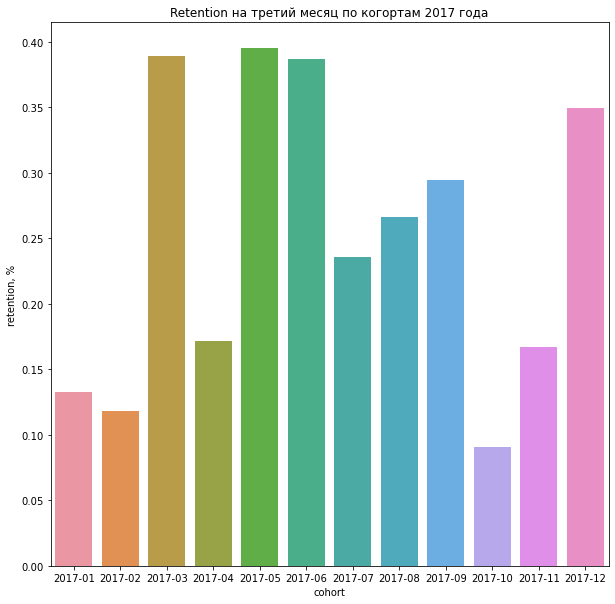

In [65]:
# визуализируем показатели retention на третий месяц после формирования когорты
plt.figure(figsize=(10,10))
sns.barplot(data=retention[[3]].reset_index(),
            y=retention[[3]].mul(100).reset_index()[3],
            x='cohort')
plt.ylabel('retention, %')
plt.title('Retention на третий месяц по когортам 2017 года');

Наибольшее значение retention на третий месяц наблюдается у когорты покупателей, которые совершили свою первую покупку в мае 2017 года. Близкие результаты показали когорты июня и марта 2017 года. Приблизительно 0,4% покупателей из данных когорт вернулись к нам и совершили еще как минимум одну покупку через 3 месяца от первой своей покупки у нас.

### 6. Построй RFM-кластеры для пользователей. Выведи для каждого кластера средние значения метрик R, F, M (и опиши подробно, как были построены метрики R, F, M).

RFM-кластеры делят пользователей на сегменты в зависимости от:
- давности (Recency) - разница между текущей датой и датой последнего платежа (чем меньше, тем лучше),
- частоты (Frequency) - количество транзакций (чем больше, тем лучше),
- общей суммы платежей (Monetary) - сумма покупок (чем больше, тем лучше).

Для каждого покупателя рассчитаем эти показатели и в соответствии с их значениями поставим баллы за каждый показатель от 1 до 3, где 3 - это хорошо, а 1 - плохо. Определять границы значений, по которым выставляется тот или иной балл я буду с помощью квантилей.

Для рассчета показателей Recency, Frequency и Monetary нужны данные: id клиента, дата заказа, сумма покупки. Почти готовую таблицу можно взять из предыдущих пунктов, там исключены несостоявшиеся покупки (статусы cancelled и unavailable).

In [66]:
df_customer_orders.head()

,order_id,customer_id,order_purchase_timestamp,customer_unique_id,purchase_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,2018-02


In [67]:
# оставим только необходимые столбцы
df_for_rfm = df_customer_orders.drop(columns=['customer_id', 'purchase_month'])

df_for_rfm.head()

,order_id,order_purchase_timestamp,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6


In [68]:
# сумму покупки возьмем из этой таблицы
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [69]:
df_payment_order = df_order_items\
    .groupby('order_id')\
    .agg({'price': 'sum'})\
    .reset_index()\
    .rename(columns={'price': 'payment'})

df_payment_order.head()

,order_id,payment
0,00010242fe8c5a6d1ba2dd792cb16214,58.90
1,00018f77f2f0320c557190d7a144bdd3,239.90
2,000229ec398224ef6ca0657da4fc703e,199.00
3,00024acbcdf0a6daa1e931b038114c75,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90


In [70]:
# присоединим столбец с суммами покупок
df_for_rfm = df_for_rfm.merge(df_payment_order, on='order_id', how='left')

df_for_rfm.head()

,order_id,order_purchase_timestamp,customer_unique_id,payment
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,19.90


In [71]:
# сгруппируем датафрейм по покупателям, посчитаем количество заказов (frequency),
# сколько дней прошло с последнего заказа (recency) 
# (для рассчета буду использовать не текущую дату, а возьму самую позднюю дату заказа + 1 день)
# также рассчитаем общую сумму денег, которую принес нам покупатель (monetary)

last_date = df_for_rfm.order_purchase_timestamp.max() + timedelta(days=1)

rfm_df = df_for_rfm\
    .groupby('customer_unique_id')\
    .agg({'order_purchase_timestamp': lambda x: (last_date - x.max()).days,
          'order_id': 'count',
          'payment': 'sum'})\
    .reset_index()\
    .rename(columns={'order_id': 'frequency',
                     'order_purchase_timestamp': 'recency',
                     'payment': 'monetary'})

rfm_df

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
2,0000f46a3911fa3c0805444483337064,542,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00
...,...,...,...,...
94985,fffcf5a5ff07b0908bd4e2dbc735a684,452,1,1570.00
94986,fffea47cd6d3cc0a88bd621562a9d061,267,1,64.89
94987,ffff371b4d645b6ecea244b27531430a,573,1,89.90
94988,ffff5962728ec6157033ef9805bacc48,124,1,115.00


Так как продакт-менеджер Василий не сообщил, по какому бизнесу компании предоставлены данные, и не известно, это таблицы по продаже товара, который в принципе редко приобретается (например, мебель) или же более ходового, то было принято решение не исключать из разделения на RFM-кластеры покупателей, которые не сделали ни одной покупки за прошедший год.

In [72]:
# проставим баллы от 1 до 3 по квантилям

# Чем меньше recency, тем выше должен быть балл
rfm_df['R'] = 4 - (pd.qcut(rfm_df.recency, 3, labels=False) + 1)

In [73]:
pd.qcut(rfm_df.recency, 3).value_counts()

(0.999, 154.0]    31821
(295.0, 729.0]    31637
(154.0, 295.0]    31532
Name: recency, dtype: int64

In [74]:
# получились приблизительно равные группы
rfm_df['R'].value_counts()

3    31821
1    31637
2    31532
Name: R, dtype: int64

In [75]:
# посмотрим распределение значений частоты заказов
rfm_df['frequency'].value_counts().sort_values(ascending=False)

1     92102
2      2652
3       188
4        29
5         9
6         5
7         3
9         1
16        1
Name: frequency, dtype: int64

Так как у нас очень много покупателей, которые совершили только одну покупку, то разделить на приблизительно равные группы с помощью функции pd.qcut не представляется возможным.

In [76]:
# Чем больше frequency, тем выше балл.
# произведем разделение на группы вручную, для этого напишем функцию
def get_f(f):
    if f==1:
        return 1
    elif f==2:
        return 2
    else:
        return 3

In [77]:
# применим функцию к столбцу с количеством заказов
rfm_df['F'] = rfm_df['frequency'].apply(get_f)

In [78]:
# разделение получилось неравномерным, но в этом случае это неизбежно
rfm_df['F'].value_counts()

1    92102
2     2652
3      236
Name: F, dtype: int64

In [79]:
# Чем больше monetary, тем выше должен быть балл
rfm_df['M'] = pd.qcut(rfm_df.monetary, 3, labels=False) + 1

In [80]:
pd.qcut(rfm_df.monetary, 3).value_counts()

(-0.001, 58.9]       31747
(128.89, 13440.0]    31661
(58.9, 128.89]       31582
Name: monetary, dtype: int64

In [81]:
# получились примерно равные группы
rfm_df['M'].value_counts()

1    31747
3    31661
2    31582
Name: M, dtype: int64

In [82]:
# посмотрим на средние значения метрик в присвоенных им группах
r_mean = rfm_df.groupby('R')\
                .agg({'recency': 'mean'})\
                .reset_index()\
                .rename(columns={'R': 'score', 
                                 'recency': 'recency_mean'})

f_mean = rfm_df.groupby('F')\
                .agg({'frequency': 'mean'})\
                .reset_index()\
                .rename(columns={'F': 'score', 'frequency': 'frequency_mean'})

m_mean = rfm_df.groupby('M')\
                .agg({'monetary': 'mean'})\
                .reset_index()\
                .rename(columns={'M': 'score', 'monetary': 'monetary_mean'})

rfm_mean = r_mean.merge(f_mean, on='score').merge(m_mean, on='score')
rfm_mean

,score,recency_mean,frequency_mean,monetary_mean
0,1,424.048393,1.000000,34.970921
1,2,225.885196,2.000000,89.464077
2,3,81.296314,3.394068,301.908481


In [83]:
rfm_df.sort_values(['R', 'F', 'M'])

,customer_unique_id,recency,frequency,monetary,R,F,M
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1
10,0006fdc98a402fceb4eb0ee528f6a8d4,412,1,13.90,1,1,1
15,000bfa1d2f1a41876493be685390d6d3,339,1,35.00,1,1,1
34,00191a9719ef48ebb5860b130347bf33,502,1,47.90,1,1,1
35,001926cef41060fae572e2e7b30bd2a4,382,1,48.79,1,1,1
...,...,...,...,...,...,...,...
89408,f0e310a6839dce9de1638e0fe5ab282a,152,6,438.09,3,3,3
90890,f4d1502ace38b0df6f052a5544add9f4,145,3,330.88,3,3,3
92339,f8bc1d81f395f6239a2a5ab1b9edf1ab,14,3,318.54,3,3,3
94064,fd8ccc89be43894d2553494c71a61fd8,138,3,179.44,3,3,3


In [84]:
# создадим столбец с кластерами
rfm_df['RFM_cluster'] = rfm_df.R.apply(str) + rfm_df.F.apply(str) + rfm_df.M.apply(str)

# а также столбец с суммой баллов кластера
rfm_df['RFM_score'] = rfm_df[['R','F','M']].sum(axis=1)

In [85]:
rfm_df

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_cluster,RFM_score
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,3,1,3,313,7
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,3,1,1,311,5
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2,112,4
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1,111,3
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,1,3,213,6
...,...,...,...,...,...,...,...,...,...
94985,fffcf5a5ff07b0908bd4e2dbc735a684,452,1,1570.00,1,1,3,113,5
94986,fffea47cd6d3cc0a88bd621562a9d061,267,1,64.89,2,1,2,212,5
94987,ffff371b4d645b6ecea244b27531430a,573,1,89.90,1,1,2,112,4
94988,ffff5962728ec6157033ef9805bacc48,124,1,115.00,3,1,2,312,6


In [86]:
"""
Функция, выдающая описание кластеров на основе баллов по показателям r, f и m.
На вход принимает столбец с кластерами формата string, где первый элемент - балл за recency,
второй - за frequency, третий - за monetary.
"""
def cluster_describe(rfm):
    if rfm[0] == '1':
        a = 'Покупали давно, '
    elif rfm[0] == '2':
        a = 'Покупали относительно недавно, '
    elif rfm[0] == '3':
        a = 'Покупали недавно, '
        
    if rfm[1] == '1':
        b = '1 заказ, '
    elif rfm[1] == '2':
        b = '2 заказа, '
    elif rfm[1] == '3':
        b = 'больше 2-х заказов, '
        
    if rfm[2] == '1':
        c = 'маленькая выручка'
    elif rfm[2] == '2':
        c = 'средняя выручка'
    elif rfm[2] == '3':
        c = 'большая выручка'
    
    return a+b+c

In [87]:
# создадим новый столбец с описаниями кластеров
rfm_df['description'] = rfm_df['RFM_cluster'].apply(cluster_describe)

In [88]:
# выведем кластеры с их описанием, количеством клиентов в них и средними значениями r, m, f,
# а также общим RFM_score (суммой баллов показателей)
rfm_df\
    .groupby(['RFM_score', 'RFM_cluster', 'description'])\
    .agg({'customer_unique_id': 'count',
         'recency': 'mean',
         'frequency': 'mean',
         'monetary': 'mean'})\
    .rename(columns={'customer_unique_id': 'num_customers',
                    'recency': 'mean_recency',
                    'frequency': 'mean_frequency',
                    'monetary': 'mean_monetary'})

num_customers  \
RFM_score RFM_cluster description                                                         
3         111         Покупали давно, 1 заказ, маленькая выручка                  10433   
4         112         Покупали давно, 1 заказ, средняя выручка                    10526   
          121         Покупали давно, 2 заказа, маленькая выручка                    69   
          211         Покупали относительно недавно, 1 заказ, маленьк...          10719   
5         113         Покупали давно, 1 заказ, большая выручка                     9827   
          122         Покупали давно, 2 заказа, средняя выручка                     227   
          131         Покупали давно, больше 2-х заказов, маленькая в...              6   
          212         Покупали относительно недавно, 1 заказ, средняя...           9937   
          221         Покупали относительно недавно, 2 заказа, малень...             59   
          311         Покупали недавно, 1 заказ, маленькая выручка                10394   
6         123         Покупали давно, 2 заказа, большая выручка                     491   
          132         Покупали давно, больше 2-х заказов, средняя выр...              7   
          213         Покупали относительно недавно, 1 заказ, большая...           9891   
          222         Покупали относительно недавно, 2 заказа, средня...            225   
          231         Покупали относительно недавно, больше 2-х заказ...              1   
          312         Покупали недавно, 1 заказ, средняя выручка                  10398   
          321         Покупали недавно, 2 заказа, маленькая выручка                  66   
7         133         Покупали давно, больше 2-х заказов, большая выр...             51   
          223         Покупали относительно недавно, 2 заказа, больша...            637   
          232         Покупали относительно недавно, больше 2-х заказ...              9   
          313         Покупали недавно, 1 заказ, большая выручка                   9977   
          322         Покупали недавно, 2 заказа, средняя выручка                   240   
8         233         Покупали относительно недавно, больше 2-х заказ...             54   
          323         Покупали недавно, 2 заказа, большая выручка                   638   
          332         Покупали недавно, больше 2-х заказов, средняя в...             13   
9         333         Покупали недавно, больше 2-х заказов, большая в...             95   

                                                                          mean_recency  \
RFM_score RFM_cluster description                                                        
3         111         Покупали давно, 1 заказ, маленькая выручка            425.875491   
4         112         Покупали давно, 1 заказ, средняя выручка              423.021376   
          121         Покупали давно, 2 заказа, маленькая выручка           435.507246   
          211         Покупали относительно недавно, 1 заказ, маленьк...    225.425879   
5         113         Покупали давно, 1 заказ, большая выручка              424.365015   
          122         Покупали давно, 2 заказа, средняя выручка             408.488987   
          131         Покупали давно, больше 2-х заказов, маленькая в...    578.166667   
          212         Покупали относительно недавно, 1 заказ, средняя...    226.825803   
          221         Покупали относительно недавно, 2 заказа, малень...    223.389831   
          311         Покупали недавно, 1 заказ, маленькая выручка           79.971041   
6         123         Покупали давно, 2 заказа, большая выручка             408.171079   
          132         Покупали давно, больше 2-х заказов, средняя выр...    411.714286   
          213         Покупали относительно недавно, 1 заказ, большая...    225.679304   
          222         Покупали относительно недавно, 2 заказа, средня...    228.942222   
          231         Покупали относительно недавно, больше 2-х заказ...    243.00000

Помимо этого я считаю важным отдельно выделить сегмент тех потенциальных покупателей, которые хотели у нас сделать заказ, но так и не сделали ни одного. Возможно, маркетологи посчитают нужным с ними повзаимодействовать.

In [89]:
# выделим неуспешные заказы в отдельную таблицу
df_no_buy = df_orders\
    .query('(order_status == "canceled")|(order_status == "unavailable")')\
    .loc[:, ['order_id', 'customer_id', 'order_purchase_timestamp']]

df_no_buy

,order_id,customer_id,order_purchase_timestamp
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,2017-11-16 15:09:28
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,2018-08-04 14:29:27
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,2018-01-31 11:31:37
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,2018-01-26 21:34:08
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,2017-08-14 17:38:02
...,...,...,...
99252,aaab15da689073f8f9aa978a390a69d1,df20748206e4b865b2f14a5eabbfcf34,2018-01-16 14:27:59
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,2018-08-31 16:13:44
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,2018-09-06 18:45:47
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,2017-08-23 16:28:04


In [90]:
# присоединим к получившейся таблице столбец соответствий customer_unique_id
# и удалим столбец неуникальных customer_id
df_no_buy = df_no_buy.merge(df_customers.loc[:, ['customer_id', 'customer_unique_id']], 
                            on='customer_id',
                            how='left').drop(columns={'customer_id'})

df_no_buy

,order_id,order_purchase_timestamp,customer_unique_id
0,8e24261a7e58791d10cb1bf9da94df5c,2017-11-16 15:09:28,41fc647b8c6bd979b1b6364b60471b50
1,1b9ecfe83cdc259250e1a8aca174f0ad,2018-08-04 14:29:27,8ea097b1824dbd4d17af71b0afe04301
2,c272bcd21c287498b4883c7512019702,2018-01-31 11:31:37,0e634b16e4c585acbd7b2e8276ce6677
3,714fb133a6730ab81fa1d3c1b2007291,2018-01-26 21:34:08,c4ebedb09beb89cc0314c5c0c33f8053
4,37553832a3a89c9b2db59701c357ca67,2017-08-14 17:38:02,596ed6d7a35890b3fbac54ec01f69685
...,...,...,...
1229,aaab15da689073f8f9aa978a390a69d1,2018-01-16 14:27:59,a33e0969408919ba06779f497ead93ec
1230,3a3cddda5a7c27851bd96c3313412840,2018-08-31 16:13:44,e90598185d2427a35e32ef241a5c04aa
1231,a89abace0dcc01eeb267a9660b5ac126,2018-09-06 18:45:47,d05c44a138277ad325d915c6b7ccbcdf
1232,a69ba794cc7deb415c3e15a0a3877e69,2017-08-23 16:28:04,e72a90a2b29fe1a8795b284aaaa3246f


In [91]:
# по пересечению с таблицей с успешными заказами найдем тех покупателей, 
# которые пытались, но так и не смогли у нас ничего купить
df_for_rfm

,order_id,order_purchase_timestamp,customer_unique_id,payment
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,19.90
...,...,...,...,...
98202,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a,72.00
98203,63943bddc261676b46f01ca7ac2f7bd8,2018-02-06 12:58:58,da62f9e57a76d978d02ab5362c509660,174.90
98204,83c1379a015df1e13d02aae0204711ab,2017-08-27 14:46:43,737520a9aad80b3fbbdad19b66b37b30,205.99
98205,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,5097a5312c8b157bb7be58ae360ef43c,359.98


In [92]:
df_no_buy = df_no_buy.merge(df_for_rfm[['customer_unique_id']], on='customer_unique_id', how='left', indicator=True)

In [93]:
df_no_buy

,order_id,order_purchase_timestamp,customer_unique_id,_merge
0,8e24261a7e58791d10cb1bf9da94df5c,2017-11-16 15:09:28,41fc647b8c6bd979b1b6364b60471b50,left_only
1,1b9ecfe83cdc259250e1a8aca174f0ad,2018-08-04 14:29:27,8ea097b1824dbd4d17af71b0afe04301,left_only
2,c272bcd21c287498b4883c7512019702,2018-01-31 11:31:37,0e634b16e4c585acbd7b2e8276ce6677,left_only
3,714fb133a6730ab81fa1d3c1b2007291,2018-01-26 21:34:08,c4ebedb09beb89cc0314c5c0c33f8053,both
4,37553832a3a89c9b2db59701c357ca67,2017-08-14 17:38:02,596ed6d7a35890b3fbac54ec01f69685,left_only
...,...,...,...,...
1260,aaab15da689073f8f9aa978a390a69d1,2018-01-16 14:27:59,a33e0969408919ba06779f497ead93ec,left_only
1261,3a3cddda5a7c27851bd96c3313412840,2018-08-31 16:13:44,e90598185d2427a35e32ef241a5c04aa,left_only
1262,a89abace0dcc01eeb267a9660b5ac126,2018-09-06 18:45:47,d05c44a138277ad325d915c6b7ccbcdf,left_only
1263,a69ba794cc7deb415c3e15a0a3877e69,2017-08-23 16:28:04,e72a90a2b29fe1a8795b284aaaa3246f,left_only


In [94]:
# отфильтруем таблицу и удалим вспомогательный столбец
# теперь получилась таблица с нашими несостоявшимися покупателями
df_no_buy = df_no_buy.query('_merge=="left_only"').drop(columns={'_merge'})
df_no_buy

,order_id,order_purchase_timestamp,customer_unique_id
0,8e24261a7e58791d10cb1bf9da94df5c,2017-11-16 15:09:28,41fc647b8c6bd979b1b6364b60471b50
1,1b9ecfe83cdc259250e1a8aca174f0ad,2018-08-04 14:29:27,8ea097b1824dbd4d17af71b0afe04301
2,c272bcd21c287498b4883c7512019702,2018-01-31 11:31:37,0e634b16e4c585acbd7b2e8276ce6677
4,37553832a3a89c9b2db59701c357ca67,2017-08-14 17:38:02,596ed6d7a35890b3fbac54ec01f69685
5,d57e15fb07fd180f06ab3926b39edcd2,2018-01-08 19:39:03,2349bbb558908e0955e98d47dacb7adb
...,...,...,...
1260,aaab15da689073f8f9aa978a390a69d1,2018-01-16 14:27:59,a33e0969408919ba06779f497ead93ec
1261,3a3cddda5a7c27851bd96c3313412840,2018-08-31 16:13:44,e90598185d2427a35e32ef241a5c04aa
1262,a89abace0dcc01eeb267a9660b5ac126,2018-09-06 18:45:47,d05c44a138277ad325d915c6b7ccbcdf
1263,a69ba794cc7deb415c3e15a0a3877e69,2017-08-23 16:28:04,e72a90a2b29fe1a8795b284aaaa3246f


In [95]:
# вычислим процент покупателей, у которых не получилось ничего у нас купить, от общего количества уникальных покупателей
round(df_no_buy.customer_unique_id.nunique()*100/df_customers.customer_unique_id.nunique(), 2)

1.15

In [96]:
# посмотрим, были ли те, кто пытался сделать заказ несколько раз
df_no_buy.groupby('customer_unique_id')\
    .agg({'order_id': 'count'})\
    .reset_index()\
    .rename(columns={'order_id': 'orders_num'})\
    .sort_values('orders_num')\
    .query('orders_num>1')

,customer_unique_id,orders_num
274,3eb7932f075743f0e50b0d9966707e6f,2
897,d05c44a138277ad325d915c6b7ccbcdf,2
109,1a674d0bad43d5b5c387fce838e4c428,2
237,391d6062da3dd65b4de4524f28c478de,2
1004,e9d6ce102dcb8ab8a3387021b5040f70,2
613,8cda74bcb48b709a90e5441e19b1d759,2
677,9eb7d30b5661dd9e5e2333954d84e02a,2
1034,ef0103e9602d12594d19c2b666219bc1,3


С помощью приведенного RFM-анализа, а также дополнительного исследования несостоявшихся по тем или иным причинам покупателей, мы можем провести прицельную работу с разными группами наших клиентов. Например, для тех клиентов, у которых 9 баллов RFM, разработать программу лояльности. Для клиентов из кластеров 233, 232, 223 придумать маркетинговую акцию, профилактирующую возможный отток клиентов. Для клиентов из кластеров 133 и 123 сделать такие ценовые предложения, от которых сложно отказаться, чтобы вернуть ценных "оттекших" клиентов. И так далее. Также можно обратить внимание на тех покупателей, у которых не получилось ничего у нас купить (их 1.15% от общего количества наших клиентов).